In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline

import lightgbm as lgb

import time
import pickle
import gc

In [2]:
df_final = pd.read_csv('./data/data_final_05082019.csv')

In [3]:
df_final.head()

,Unnamed: 0,zipcode,date,Mail_Number,statusNum,time,cate,hPa,Temper_C,Wind,Rain_mm,rate_sun,zipcode_3D
0,1,10000,2018-01-03,A04221400105370,I,16:15:04,32,1015.2,21.7,11.8,0.0,53.9,100
1,2,10000,2018-01-03,A14611700101074,I,10:54:12,32,1015.2,21.7,11.8,0.0,53.9,100
2,3,10000,2018-01-03,A18749400105670,I,15:52:51,11,1015.2,21.7,11.8,0.0,53.9,100
3,4,10000,2018-01-03,A90592422000210236009,I,13:25:14,11,1015.2,21.7,11.8,0.0,53.9,100
4,5,10000,2018-01-03,A93511810005510104002,I,14:58:28,11,1015.2,21.7,11.8,0.0,53.9,100


# Data Preprocessing

### Encoding and Change Datatype

In [5]:
df_final['statusNum'] = df_final['statusNum'].apply(lambda x: 1 if x == 'I' else 0).astype('int8')

In [109]:
df_final = df_final.drop(['Unnamed: 0', 'Mail_Number'], axis=1)
df_final.zipcode = df_final.zipcode.astype('str')
df_final.cate = df_final.cate.astype('int8')
df_final.hPa = df_final.hPa.astype('float16')
df_final.Temper_C = df_final.Temper_C.astype('float16')
df_final.Wind = df_final.Wind.astype('float16')
df_final.Rain_mm = df_final.Rain_mm.astype('float16')
df_final.rate_sun = df_final.rate_sun.astype('float16')
df_final.zipcode_3D = df_final.zipcode_3D.astype('str')

# Label Encode: cate, zipcode and zipcode_3D
df_final['cate'] = LabelEncoder().fit_transform(df_final['cate']).astype('int8')
df_final['zipcode'] = LabelEncoder().fit_transform(df_final['zipcode']).astype('int16')
df_final['zipcode_3D'] = LabelEncoder().fit_transform(df_final['zipcode_3D']).astype('int16')
gc.collect()

829

### Fill NaN in Weather Data with Proper Values

In [71]:
def fill_na(df):
    for col in df.columns:
        if df[col].isnull().any():
            if col == 'hPa' or 'Temper_C' or 'Wind' or 'rate_sun':
                print(col)
                group = df.groupby('date')[[col]].median()
                index_nan = df[df[col].isnull()].index
                df.loc[index_nan, col] = df.loc[index_nan, 'date'].apply(lambda x: group[group.index == x][col].values[0])
            elif col == 'Rain_mm':
                df[col].fillna(0, inplace=True)
    return df
df_final = fill_na(df_final)

hPa
Temper_C
Wind
Rain_mm
rate_sun


### Select Datetime Features

In [72]:
df_final['datetime'] = pd.to_datetime(df_final.loc[:,'date'] + " " + df_final.loc[:,'time'])
# df_final['month'] = df_final.datetime.dt.month.astype('int8')
df_final['weekday'] = df_final.datetime.dt.weekday.astype('int8')
df_final['hour'] = df_final.datetime.dt.hour.astype('int8')

df_final = df_final.drop(['date', 'time', 'datetime'], axis=1)
gc.collect()

2168

In [107]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14006444 entries, 0 to 14006443
Data columns (total 12 columns):
zipcode       int16
statusNum     int8
cate          int16
hPa           float16
Temper_C      float16
Wind          float16
Rain_mm       float16
rate_sun      float16
zipcode_3D    int16
month         int8
weekday       int8
hour          int8
dtypes: float16(5), int16(3), int8(4)
memory usage: 267.2 MB


In [154]:
df_final.to_pickle('data.pkl')
del df_final
gc.collect()

# Modeling: Test with LightGBM

In [155]:
df_final = pd.read_pickle('./data/data.pkl')

### Split/Resample/Scale

In [146]:
X_train = df_final[df_final['month'] < 3].drop(['statusNum'], axis=1)
Y_train = df_final[df_final['month'] < 3]['statusNum']
X_test = df_final[df_final['month'] >= 3].drop(['statusNum'], axis=1)
Y_test = df_final[df_final['month'] >= 3]['statusNum']

In [147]:
X_train.head()

,zipcode,cate,hPa,Temper_C,Wind,Rain_mm,rate_sun,zipcode_3D,month,weekday,hour
0,0,11,1015.0,21.703125,11.796875,0.0,53.90625,0,1,2,16
1,0,11,1015.0,21.703125,11.796875,0.0,53.90625,0,1,2,10
2,0,0,1015.0,21.703125,11.796875,0.0,53.90625,0,1,2,15
3,0,0,1015.0,21.703125,11.796875,0.0,53.90625,0,1,2,13
4,0,0,1015.0,21.703125,11.796875,0.0,53.90625,0,1,2,14


In [148]:
# random sample
random_sample = random.sample(list(Y_train[Y_train == 1].index), k=len(Y_train[Y_train == 0]))
random_sample = random_sample + list(Y_train[Y_train == 0].index)
X_train = X_train.loc[random_sample]
Y_train = Y_train.loc[random_sample]

In [149]:
X_train.loc[random_sample].head()

,zipcode,cate,hPa,Temper_C,Wind,Rain_mm,rate_sun,zipcode_3D,month,weekday,hour
8226881,6302,8,1009.5,17.296875,9.500000,2.0,0.0000,111,1,4,13
6033249,3040,8,1009.5,16.796875,10.601562,0.0,0.0000,44,2,2,14
5417068,2556,1,1014.5,18.703125,6.000000,0.0,65.6875,38,1,1,17
5515156,2693,0,895.0,5.699219,18.203125,17.0,0.0000,40,1,1,12
13595636,15751,0,1013.5,17.093750,5.898438,0.0,79.3125,311,2,2,12


In [150]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# split valid set from test set
length_valid = int(len(X_test)*0.3)
X_valid = X_test[:length_valid]
Y_valid = Y_test[:length_valid]
X_test = X_test[length_valid:]
Y_test = Y_test[length_valid:]

C:\Users\USER\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int8, float16, int16 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\USER\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int8, float16, int16 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
C:\Users\USER\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int8, float16, int16 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [151]:
del df_final
gc.collect()

734

In [115]:
train_data=lgb.Dataset(X_train,label=Y_train)
valid_data=lgb.Dataset(X_valid,label=Y_valid)

params = {'boosting_type': 'gbdt',
          'max_depth' : -1,
          'objective': 'regression',
          'nthread': 5,
          'num_leaves': 32,
          'learning_rate': 0.005,
          'subsample': 0.8,
          'subsample_freq': 1,
          'colsample_bytree': 0.8,
          'min_split_gain': 0.5,
          'min_child_weight': 1,
          'min_child_samples': 1,
          'metric' : 'rmse'
          }

model = lgb.train(params,
                 train_data,
                 25000,
                 valid_sets=[train_data, valid_data],
                 early_stopping_rounds= 20,
                 verbose_eval= 20
                 )

Training until validation scores don't improve for 20 rounds.
[20]	training's rmse: 0.496559	valid_1's rmse: 0.496175
[40]	training's rmse: 0.492884	valid_1's rmse: 0.492461
[60]	training's rmse: 0.490203	valid_1's rmse: 0.489382
[80]	training's rmse: 0.487656	valid_1's rmse: 0.486729
[100]	training's rmse: 0.485532	valid_1's rmse: 0.484559
[120]	training's rmse: 0.483278	valid_1's rmse: 0.482421
[140]	training's rmse: 0.481832	valid_1's rmse: 0.480927
[160]	training's rmse: 0.480329	valid_1's rmse: 0.479395
[180]	training's rmse: 0.478738	valid_1's rmse: 0.477915
[200]	training's rmse: 0.477557	valid_1's rmse: 0.476778
[220]	training's rmse: 0.476439	valid_1's rmse: 0.47594
[240]	training's rmse: 0.47529	valid_1's rmse: 0.475074
[260]	training's rmse: 0.474331	valid_1's rmse: 0.474085
[280]	training's rmse: 0.473464	valid_1's rmse: 0.473456
[300]	training's rmse: 0.472832	valid_1's rmse: 0.472662
[320]	training's rmse: 0.472185	valid_1's rmse: 0.472042
[340]	training's rmse: 0.471614	

In [116]:
Y_pred = (model.predict(X_test) > 0.5).astype('int8')
# Y_pred
confusion_matrix(Y_test, Y_pred)

array([[ 388786,  167831],
       [1361904, 1996099]], dtype=int64)

In [117]:
accuracy_score(Y_test, Y_pred)

0.6092251610628874

In [89]:
print("Y_train: {}:{}".format(Y_train[Y_train == 1].shape, Y_train[Y_train == 0].shape))
print("Y_test: {}:{}".format(Y_test[Y_test == 1].shape, Y_test[Y_test == 0].shape))
print("Y_train Fail Rate: {}".format(Y_train[Y_train == 0].shape[0]/Y_train.shape[0]))
print("Y_test Fail Rate: {}".format(Y_test[Y_test == 0].shape[0]/Y_test.shape[0]))

Y_train: (1206054,):(1206054,)
Y_test: (3358003,):(556617,)
Y_train Fail Rate: 0.5
Y_test Fail Rate: 0.1421892801855608


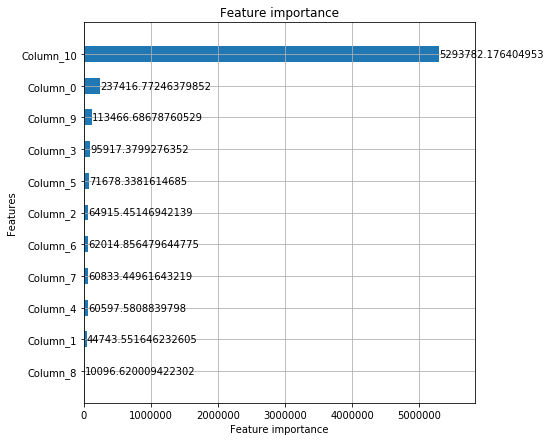

In [118]:
lgb.plot_importance(model, height=0.5, ignore_zero = False, figsize = (7, 7), importance_type ='gain')

# Futher Analysis

### Hour

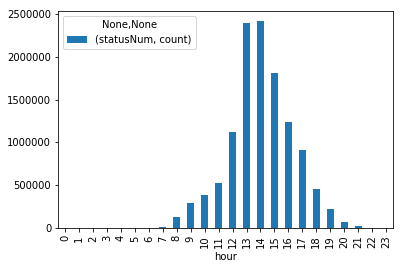

In [126]:
hour_success = df_final[df_final['statusNum'] == 1].groupby('hour').agg({'statusNum': ['count']})
hour_success.plot(kind='bar')

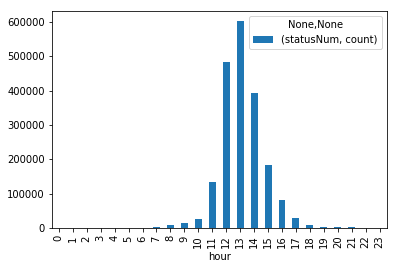

In [128]:
hour_fail = df_final[df_final['statusNum'] == 0].groupby('hour').agg({'statusNum': ['count']})
hour_fail.plot(kind='bar')

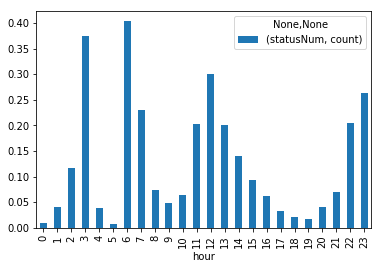

In [138]:
hour_fail_rate = hour_fail/(hour_fail+hour_success)
hour_fail_rate.plot(kind='bar')

According to the fail rate plot (by hour), we suggest delivering more mails in the **morning(8~9)** and **afternoon(3~7)**.

### Weekday

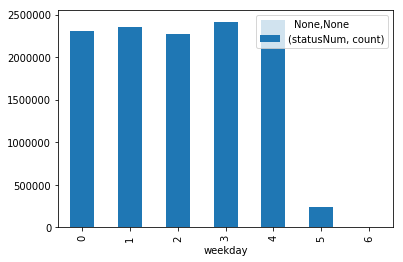

In [139]:
week_success = df_final[df_final['statusNum'] == 1].groupby('weekday').agg({'statusNum': ['count']})
week_success.plot(kind='bar')

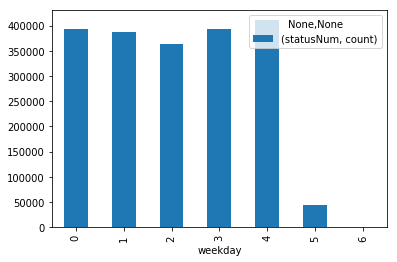

In [140]:
week_fail = df_final[df_final['statusNum'] == 0].groupby('weekday').agg({'statusNum': ['count']})
week_fail.plot(kind='bar')

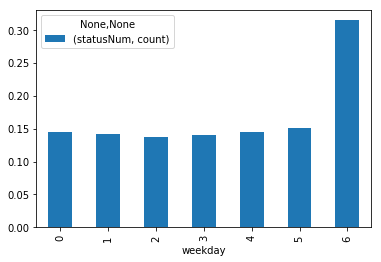

In [142]:
week_fail_rate = week_fail/(week_fail+week_success)
week_fail_rate.plot(kind='bar')

According to the fail rate plot (by weekday), we suggest avoiding delivering mails on Sunday.